<a href="https://colab.research.google.com/github/akhilkapil/NLP-Transfer_Learning_Models/blob/main/NLP_Amazon_Mobile_Electronics_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import nltk
nltk.download('punkt')

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import pkg_resources

In [ ]:
dataset, info = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', with_info = True)
train_dataset = dataset['train']

In [ ]:
train_dataset

<DatasetV1Adapter shapes: {data: {customer_id: (), helpful_votes: (), marketplace: (), product_category: (), product_id: (), product_parent: (), product_title: (), review_body: (), review_date: (), review_headline: (), review_id: (), star_rating: (), total_votes: (), verified_purchase: (), vine: ()}}, types: {data: {customer_id: tf.string, helpful_votes: tf.int32, marketplace: tf.string, product_category: tf.string, product_id: tf.string, product_parent: tf.string, product_title: tf.string, review_body: tf.string, review_date: tf.string, review_headline: tf.string, review_id: tf.string, star_rating: tf.int32, total_votes: tf.int32, verified_purchase: tf.int64, vine: tf.int64}}>

In [ ]:
BUFFER_SIZE = 3000
BATCH_SIZE = 128

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)

In [ ]:
for reviews in train_dataset.take(2):
  print(reviews)

{'data': {'customer_id': <tf.Tensor: shape=(), dtype=string, numpy=b'13922051'>, 'helpful_votes': <tf.Tensor: shape=(), dtype=int32, numpy=0>, 'marketplace': <tf.Tensor: shape=(), dtype=string, numpy=b'US'>, 'product_category': <tf.Tensor: shape=(), dtype=string, numpy=b'Mobile_Electronics'>, 'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'B00AMAISIY'>, 'product_parent': <tf.Tensor: shape=(), dtype=string, numpy=b'1823189'>, 'product_title': <tf.Tensor: shape=(), dtype=string, numpy=b'VPR Black Leather Folio Cover Case for 6" Kindle Wi-Fi E-Ink Display without Keyboard (Not for Kindle Touch or Kindle Paperwhite)'>, 'review_body': <tf.Tensor: shape=(), dtype=string, numpy=b'This is a really nice, simple, black leather Kindle case. It offers great protection and even has a little pocket inside the front cover for notes. Terrific value for the money.'>, 'review_date': <tf.Tensor: shape=(), dtype=string, numpy=b'2013-05-08'>, 'review_headline': <tf.Tensor: shape=(), dtype=string,

In [ ]:
for reviews in train_dataset.take(10):
  review_text = reviews['data']
  print(review_text.get('review_body').numpy())
  print(review_text.get('star_rating'))
  print(tf.where(review_text.get('star_rating') > 3,1,0).numpy()) # here i am giving rating 4 or 5 as a posiitive sentiment and rating 1,2,3 as a negative sentiment

b'This is a really nice, simple, black leather Kindle case. It offers great protection and even has a little pocket inside the front cover for notes. Terrific value for the money.'
tf.Tensor(5, shape=(), dtype=int32)
1
b'high quality. love it.'
tf.Tensor(5, shape=(), dtype=int32)
1
b'i like the color and the style. easy to use. sturdy so the device does not get scratched. good price'
tf.Tensor(4, shape=(), dtype=int32)
1
b"I've had this case for almost 2 years now and it has been great. It's a simple case. I'm not asking it to protect the GPS from anything more than other things shoved into a compartment along with it but it does the job. Considering the cost I'm very happy."
tf.Tensor(5, shape=(), dtype=int32)
1
b"Skque Clear Crystal Screen Protector for Garmin Nuvi 1450/1450LMT 5-Inch : I bought this product from Amazon.com at a very reasonable price.<br />It takes a little time to put it on but, once you have done so, you've got great protection with it. It fit my Garmin very well a

In [ ]:
tokenizer = tfds.features.text.Tokenizer()

In [ ]:
# First thing to do is to tokenize the data and build the vocabulary

vocabulary = set() #We are using the set function as it will get rid of all the duplicates, this wat i will get the unique values
for  _, reviews in train_dataset.enumerate():
  reviews_text = reviews['data']
  reviews_token = tokenizer.tokenize(reviews_text.get('review_body').numpy())
  vocabulary.update(reviews_token)

In [ ]:
vocab_size = len(vocabulary)
vocab_size

73738

In [ ]:

encoder = tfds.features.text.TokenTextEncoder(vocabulary)

In [ ]:
for reviews in train_dataset.take(5):
  review_text = reviews['data']
  print(review_text.get('review_body').numpy())
  encoded_term = encoder.encode(review_text.get('review_body').numpy())
  print(encoded_term)

b'This is a really nice, simple, black leather Kindle case. It offers great protection and even has a little pocket inside the front cover for notes. Terrific value for the money.'
[22406, 12003, 40967, 71822, 13620, 66355, 26731, 34040, 25851, 71013, 30871, 38457, 70788, 41506, 53044, 42576, 62131, 40967, 47197, 3798, 18018, 40333, 56211, 5281, 54255, 36712, 72292, 48688, 54255, 40333, 34955]
b'high quality. love it.'
[54834, 37594, 2207, 16220]
b'i like the color and the style. easy to use. sturdy so the device does not get scratched. good price'
[33092, 69538, 40333, 56612, 53044, 40333, 34992, 14075, 72570, 52603, 16418, 72980, 40333, 34442, 49808, 30499, 69186, 10979, 62031, 62748]
b"I've had this case for almost 2 years now and it has been great. It's a simple case. I'm not asking it to protect the GPS from anything more than other things shoved into a compartment along with it but it does the job. Considering the cost I'm very happy."
[30791, 6978, 10605, 62915, 71013, 54255, 11

In [ ]:
encoded_term = encoder.encode(review_text.get('review_body').numpy())

In [ ]:
for index in encoded_term:
  print('{}......{}'. format(index, encoder.decode([index])))

In [ ]:
def encode(text , label_tensor):
  encoded_text = encoder.encode(text.numpy())
  label = tf.where(label_tensor > 3, 1, 0)
  return encoded_text, label

In [ ]:
def encoded_map(tensor):

  text = tensor['data'].get('review_body')
  label = tensor['data'].get('star_rating')

  encoded_text, label = tf.py_function(encode, inp=[text, label], Tout=[tf.int64, tf.int32])

  encoded_text.set_shape([None])
  label.set_shape([])

  return encoded_text, label

In [ ]:
transformed_data = train_dataset.map(encoded_map)

In [ ]:
for k0, k1 in transformed_data.take(2):
  print(k0)
  print(k1)

tf.Tensor(
[22406 12003 40967 71822 13620 66355 26731 34040 25851 71013 30871 38457
 70788 41506 53044 42576 62131 40967 47197  3798 18018 40333 56211  5281
 54255 36712 72292 48688 54255 40333 34955], shape=(31,), dtype=int64)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor([54834 37594  2207 16220], shape=(4,), dtype=int64)
tf.Tensor(1, shape=(), dtype=int32)


In [ ]:
SIZE = 10000

train_data = transformed_data.skip(SIZE).shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE) # We want to take 128 records every batch and then train the model
#padding will help in getting equal number of variables for each batch size 

test_data = transformed_data.take(SIZE)
test_data = test_data.padded_batch(BATCH_SIZE)

In [ ]:
vocab_size += 1 #after padding a new digit will come into place 0

In [ ]:
sample_text , sample_label = next(iter(test_data))
sample_text[0] , sample_label[0]

#the output will show you the batch size of 128

In [ ]:
model = tf.keras.Sequential()

In [ ]:
from tensorflow.keras.layers import Dense , Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential()
model.add((tf.keras.layers.Embedding(vocab_size,128)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
for units in [64,64]:
  model.add(Dense(64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
import os 
import datetime

logidr = os.path.join("tmp/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="/tmp/sentiment_analysis.hdf5", verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, epochs=8, validation_data=test_data) 

Epoch 1/8
742/742 [==============================] - 370s 499ms/step - loss: 0.5843 - accuracy: 0.7368 - val_loss: 0.5888 - val_accuracy: 0.7271
Epoch 2/8
742/742 [==============================] - 378s 509ms/step - loss: 0.5842 - accuracy: 0.7369 - val_loss: 0.5888 - val_accuracy: 0.7271
Epoch 3/8
742/742 [==============================] - 374s 504ms/step - loss: 0.5843 - accuracy: 0.7368 - val_loss: 0.5888 - val_accuracy: 0.7271
Epoch 4/8
742/742 [==============================] - 368s 497ms/step - loss: 0.5842 - accuracy: 0.7369 - val_loss: 0.5888 - val_accuracy: 0.7271
Epoch 5/8
742/742 [==============================] - 369s 497ms/step - loss: 0.5842 - accuracy: 0.7369 - val_loss: 0.5888 - val_accuracy: 0.7271
Epoch 6/8
543/742 [====================>.........] - ETA: 1:34 - loss: 0.5843 - accuracy: 0.7369

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


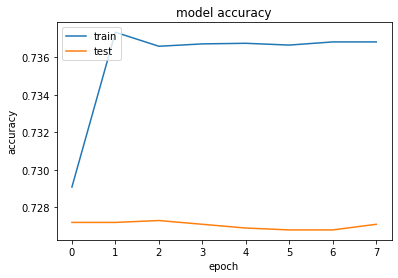

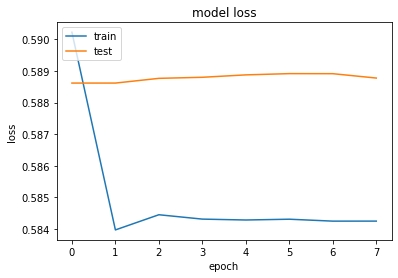

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_data, return_dict=True)

79/79 [==============================] - 26s 334ms/step - loss: 0.4019 - accuracy: 0.8506


{'accuracy': 0.850600004196167, 'loss': 0.4019276797771454}

In [ ]:
for text, label in test_data.take(1):
  print(label)
  print(model.predict(text))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(confusion_matrix(test_data, pred),annot=True, ax=ax, fmt='g', cmap='Greens')
ax.set_title('Matrix for ANN Model')

In [ ]:
model.save('tmp/final_sentiment_model.hdf5')